In [1]:
import os

CUSTOM_MODEL_NAME = 'centernet_custom' 
LABEL_MAP_NAME = 'label_map.pbtxt'



paths = {
    'WORKSPACE_PATH': os.path.join('.', 'workspace'),
    'SCRIPTS_PATH': os.path.join('.','scripts'),
    'APIMODEL_PATH': os.path.join('.','models'),
    'ANNOTATION_PATH': os.path.join('.', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('.', 'workspace','images', 'MO17D_419', 'Half_Size_1632x1224'),
    'MODEL_PATH': os.path.join('.', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('.', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('.', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('.', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('.', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('.', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('.','protoc')
 }



files = {
    'PIPELINE_CONFIG':os.path.join('.', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline_paige.config'),
    'LABELMAP': os.path.join(paths['CHECKPOINT_PATH'], LABEL_MAP_NAME)
}





for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}




In [2]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

tf.config.set_visible_devices([], 'GPU')

2021-08-20 15:53:11.443589: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-20 15:53:12.392129: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-20 15:53:12.458007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-20 15:53:12.458321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA GeForce GT 710 computeCapability: 3.5
coreClock: 0.954GHz coreCount: 1 deviceMemorySize: 980.06MiB deviceMemoryBandwidth: 11.92GiB/s
2021-08-20 15:53:12.458340: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-20 15:53:12.462446: I tensorflow/stream_executor/pla

In [3]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [4]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [5]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-35')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

2021-08-20 15:53:12.829192: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-20 15:53:12.830248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-08-20 15:53:12.830255: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      


In [6]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [8]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], '1MO17D-#419-10X-Slice1_13.jpg')

In [9]:
print(IMAGE_PATH)

./workspace/images/MO17D_419/Half_Size_1632x1224/1MO17D-#419-10X-Slice1_13.jpg


Instructions for updating:
Use `tf.cast` instead.


2021-08-20 15:53:18.583254: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-20 15:53:18.621701: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3493115000 Hz


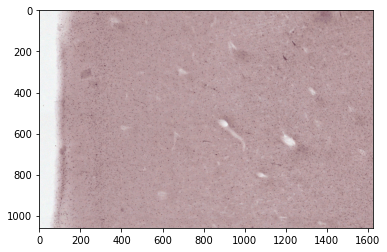

In [10]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()
